# Emission line detector
## Introduction
This is a code to test recoverability of the emission line information, namely, equivalent widths, intensities, etc...
The idea is rather simple: since the emission lines in J-PAS spetra appears as an excess in three passbands, and this three bands form a triangle with a particular shape, it should be easy to parametrize it as a function of two parameters $k_1$ and $k_2$.

## Approaches
### Trigonometric parameters
As a first approach this parameters were defined to be
$$\beta\equiv k_1-k_2,$$
where $\beta$ is the angle as shown in the figure below.

### Color parameters
This time, the parameters were defined to be
$$k_1\equiv f_1/f_2\text{ and }k_2\equiv f_3/f_1,$$

### Jesús' suggestion
During a Student Meeting, was suggested the computation of the equivalent width from the J-PAS spectra...

In [1]:
%pylab inline

import os
from astropy.io import fits
from scipy.optimize import leastsq
from copy import deepcopy as copy
from styles import slides

Populating the interactive namespace from numpy and matplotlib


In [2]:
sdir = "../inputs/real_deal/"
flist = sorted([os.path.join(root, file) for root, subs, files in os.walk(sdir+"fits") for file in files if file.endswith(".fit.gz")])
jlist = sorted([os.path.join(root, file) for root, subs, files in os.walk(sdir+"jpas") for file in files if "_JPAS_" in file])

rows = dict(Hgamma=26, Hbeta=28, OIIIa=29, OIIIb=30, NIIa=35, Halpha=36, NIIb=37, Li=38, SIIa=39, SIIb=40)
wlin = dict(Hgamma=5, Hbeta=10, OIIIa=12, OIIIb=12, NIIa=28, Halpha=28, NIIb=28, Li=30, SIIa=30, SIIb=30)
ew = dict(Hgamma=[], Hbeta=[], OIIIa=[], OIIIb=[], NIIa=[], Halpha=[], NIIb=[], Li=[], SIIa=[], SIIb=[])
er = copy(ew)
k1 = copy(ew)
k2 = copy(ew)
mk = copy(ew)

z = []
for fn, jn in zip(flist, jlist):
    f = fits.open(fn)
    wj, fj = loadtxt(jn, usecols=(0, 1), unpack=True)

    z.append(f[0].header["z"])
    
    for kw in ew:
        mk[kw].append(all(fj[wlin[kw]:wlin[kw]+3]>0.0))
        if any(fj[wlin[kw]:wlin[kw]+3]<=0.0):
            k1[kw].append(np.nan)
            k2[kw].append(np.nan)
            ew[kw].append(np.nan)
            er[kw].append(np.nan)
        else:
            k1[kw].append(fj[wlin[kw]]/fj[wlin[kw]+1])
            k2[kw].append(fj[wlin[kw]]/fj[wlin[kw]+2])
            ew[kw].append(f[2].data["ew"][rows[kw]])
            er[kw].append(f[2].data["ewErr"][rows[kw]])

In [3]:
z = array(z)

for kw in ew:
    mk[kw] = array(mk[kw])
    k1[kw] = array(k1[kw])
    k2[kw] = array(k2[kw])
    
    ew[kw] = array(ew[kw])
    er[kw] = array(er[kw])

In [4]:
mk["Hbeta,OIII"] = mk["Hbeta"]&mk["OIIIa"]&mk["OIIIb"]
ew["Hbeta,OIII"] = ew["Hbeta"]+ew["OIIIa"]+ew["OIIIb"]
k1["Hbeta,OIII"] = k1["OIIIa"]
k2["Hbeta,OIII"] = k2["OIIIa"]

mk["OIII"] = mk["OIIIa"]&mk["OIIIb"]
ew["OIII"] = ew["OIIIa"]+ew["OIIIb"]
k1["OIII"] = k1["OIIIa"]
k2["OIII"] = k2["OIIIa"]

mk["NII,Halpha,NII"] = mk["NIIa"]&mk["Halpha"]&mk["NIIb"]
ew["NII,Halpha,NII"] = ew["NIIa"]+ew["Halpha"]+ew["NIIb"]
k1["NII,Halpha,NII"] = k1["Halpha"]
k2["NII,Halpha,NII"] = k2["Halpha"]

mk["Li,SII,SII"] = mk["Li"]&mk["SIIa"]&mk["SIIb"]
ew["Li,SII,SII"] = ew["Li"]+ew["SIIa"]+ew["SIIb"]
k1["Li,SII,SII"] = k1["Li"]
k2["Li,SII,SII"] = k2["Li"]

[ -218.13276261  4668.28604491] -1.2560528324
[  -245.40504642  20220.51667497] 22.5366248231


/home/mejia/Programs/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less


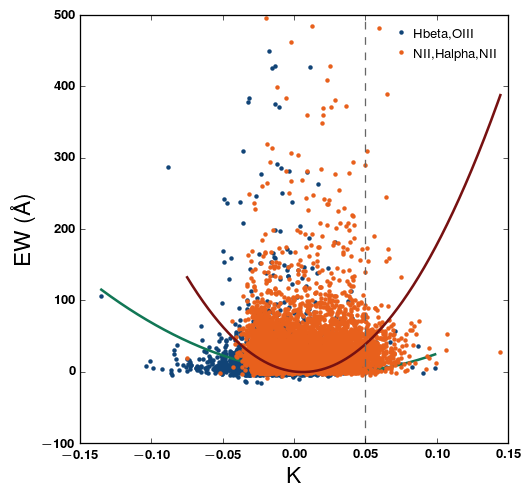

In [6]:
K = {}
#for kw in ew: K[kw] = k1[kw]
#for kw in ew: K[kw] = k2[kw]
#for kw in ew: K[kw] = (k1[kw]+k2[kw])/(k1[kw]+k2[kw])[mk[kw]].max()
for kw in ew: K[kw] = 1-(k1[kw]+k2[kw])/2

def model(K, pars):
    a, b = pars
    return a*K + b*K**2

def residual(pars, K, EW):
    return EW - model(K, pars)

for kw in ["Hbeta,OIII", "NII,Halpha,NII"]:
    inlier = (z<=0.05)&(mk[kw])&(ew[kw]<500)

    pars, n = leastsq(residual, x0=(1, 1), args=(K[kw][inlier], ew[kw][inlier]), ftol=1e-3)
    K_i = linspace(K[kw][inlier].min(), K[kw][inlier].max(), 1000)

    plot(K[kw][inlier], ew[kw][inlier], ".", label=kw)
    plot(K_i, model(K_i, pars), "-", lw=2)
    print pars, model(0.04, pars)

axvline(0.05, ls="--", color="0.4", lw=1)
legend(loc=0)
xlabel(r"K", size=18)
ylabel(r"EW (\AA)", size=18)